### 1. 数据预处理
根据地震带区域划分中国地震数据后，同一日存在多次地震的仅保留当日最大震级：
- 环太平洋地震带：台湾、东海、福建、辽宁、吉林、黑龙江
- 华北地震带：北京、天津、河北、河南、山东、内蒙古、山西、陕西、江苏、安徽
- 青藏高原地震带：西藏、四川、云南、青海
- 西北地震带：新疆，甘肃、宁夏

In [1]:
from numpy import array
from pandas import read_csv
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### 2. 读取并可视化地震震级/能量折线图

In [2]:
# 自定义读取数据
def read_data(path, col_index, col_name): 
    # path：路径
    # col_index：第几列（从0开始）
    # col_name：列名
    df = read_csv(path, usecols=[col_index], encoding='gbk')
    data = df[col_name].values
    return data

In [3]:
# 可视化四个地震带的地震震级/能量折线图
def show( d1,d2, d3, d4):   
    fig = plt.figure(figsize=(30,40))
    ax1 = fig.add_subplot(411) # “411”表示“4×1网格，第一子图”
    ax1.set_title('ThePacificOcean', fontsize=15, color='b')
    ax1.plot(d1)
    ax2 = fig.add_subplot(412)
    ax2.set_title('QinghaiTibetPlateau', fontsize=15, color='b')
    ax2.plot(d2)
    ax3 = fig.add_subplot(413)
    ax3.set_title('NorthWest', fontsize=15, color='b')
    ax3.plot(d3)
    ax4 = fig.add_subplot(414)
    ax4.set_title('NorthChina', fontsize=15, color='b')
    ax4.plot(d4)
    plt.show()

data_ThePacificOcean:612
data_QinghaiTibetPlateau:646
data_NorthWest:283
data_NorthChina:62


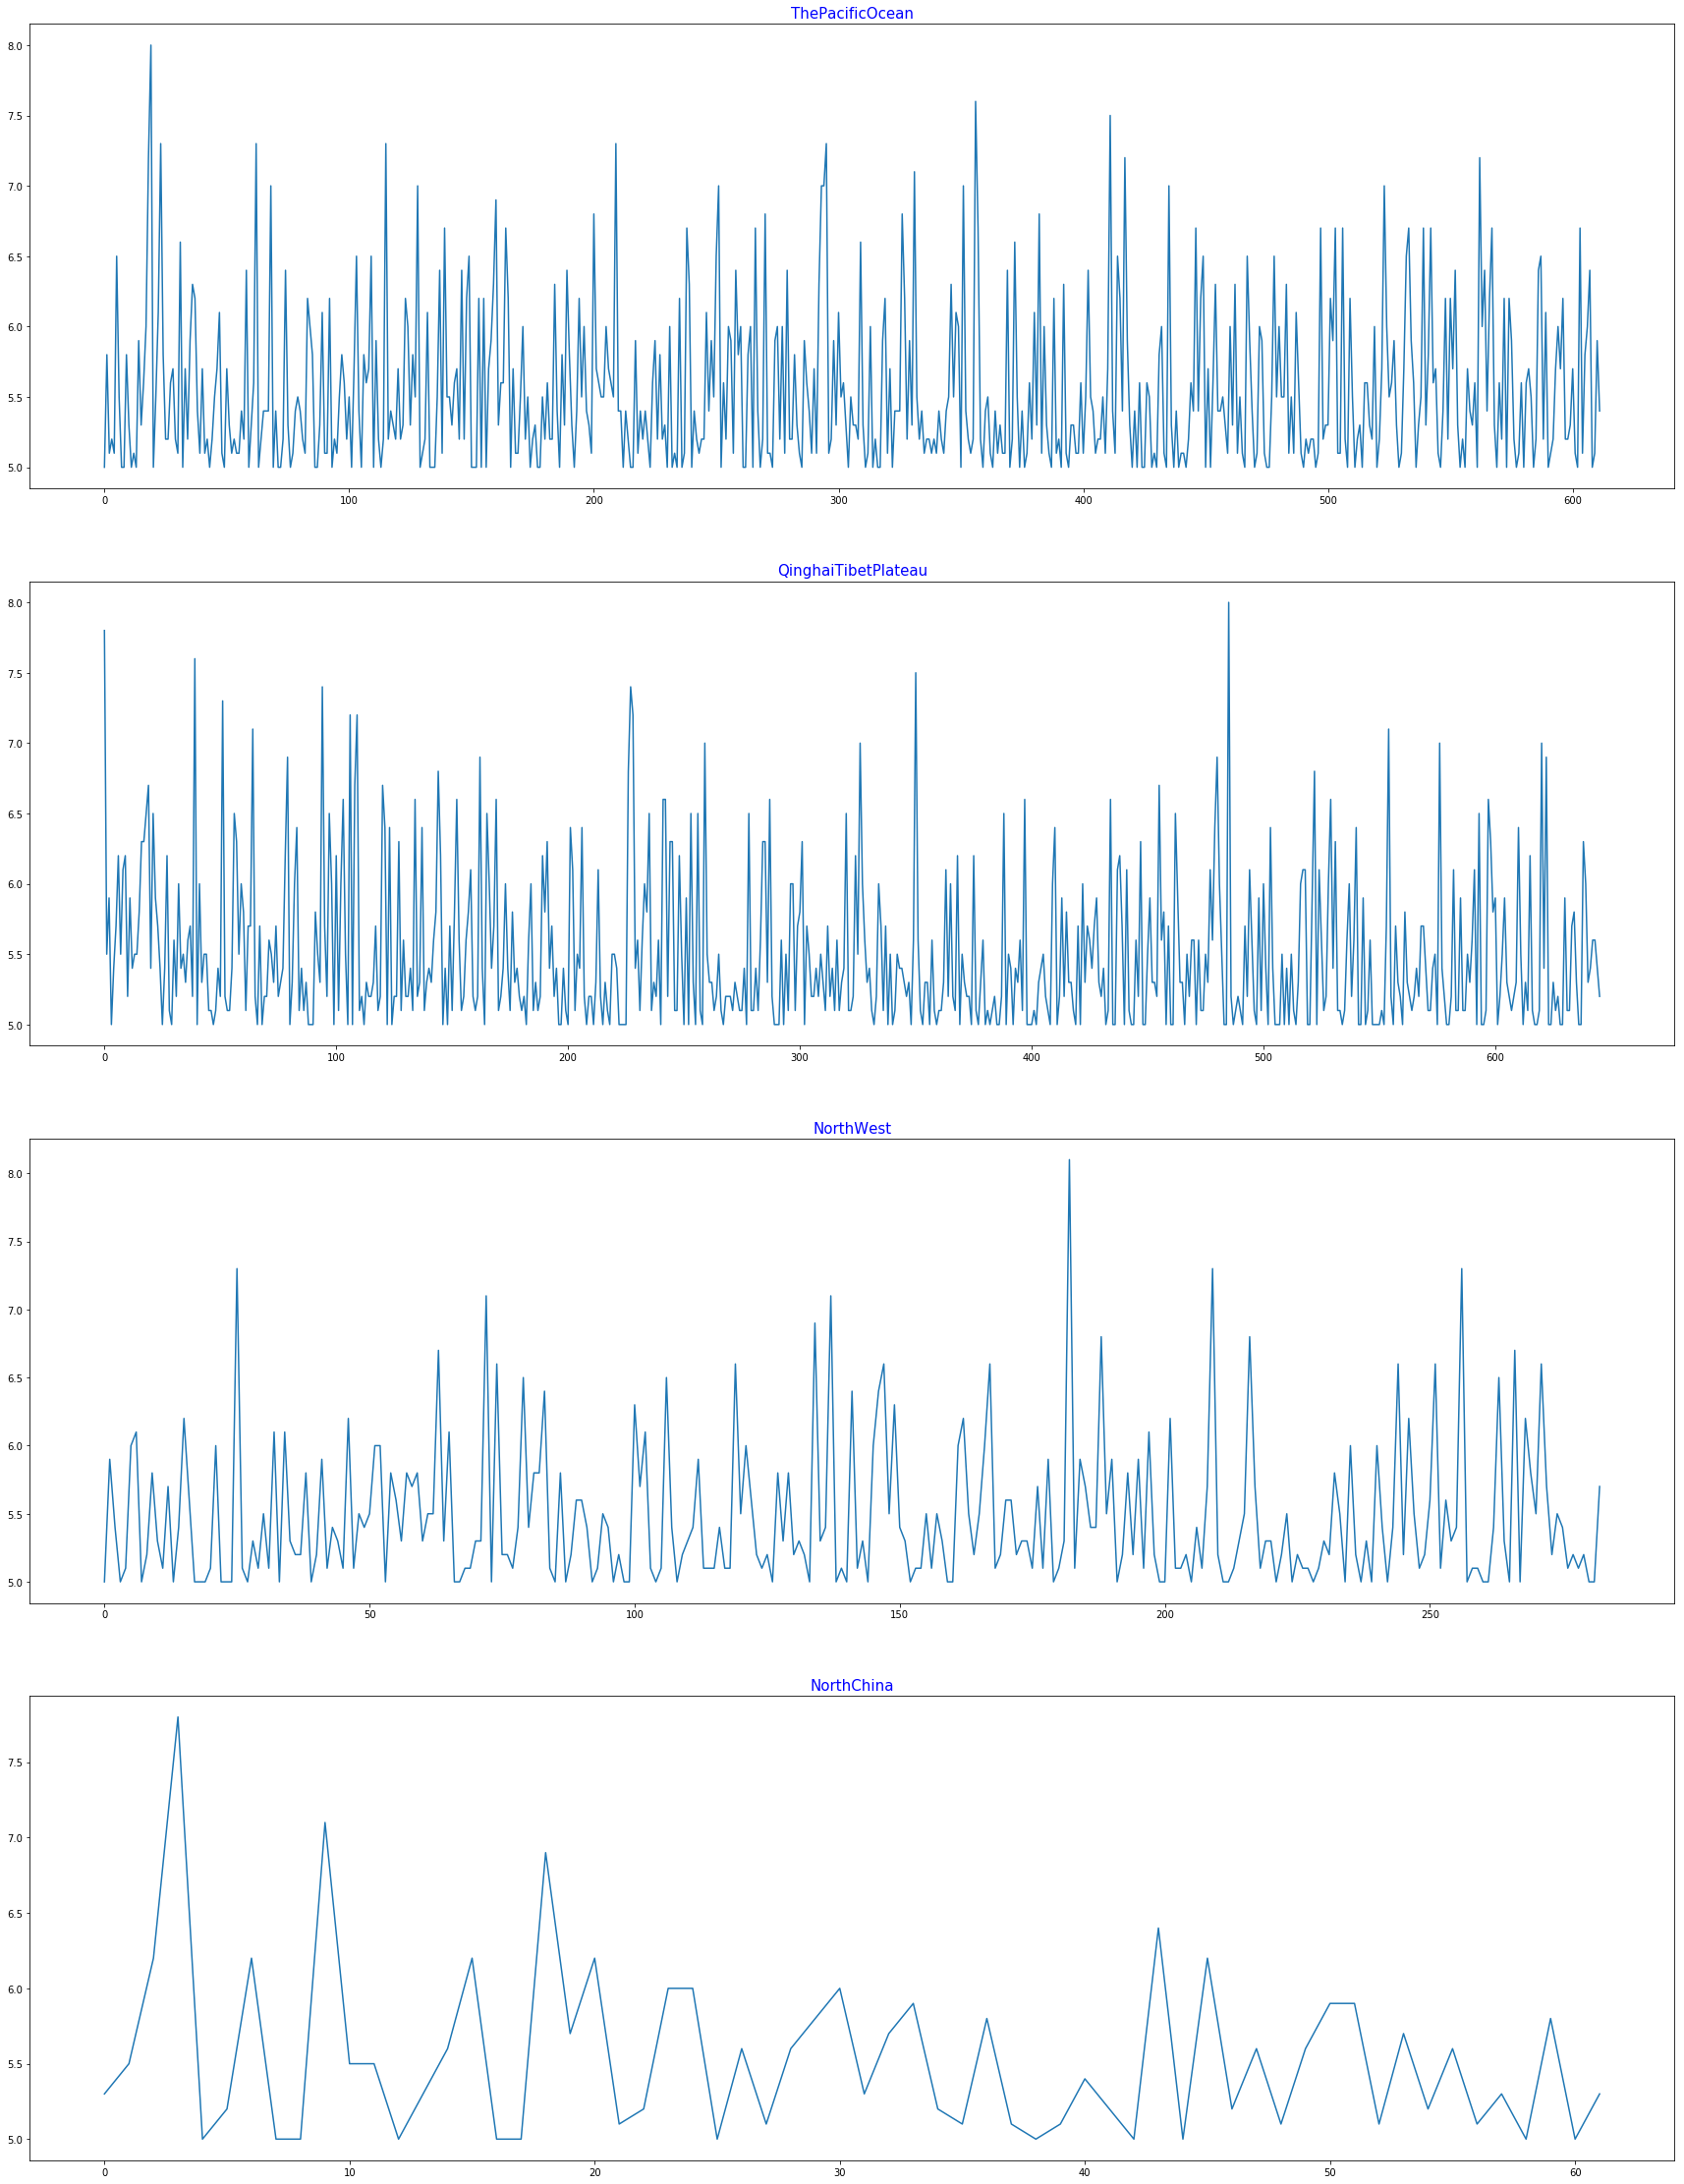

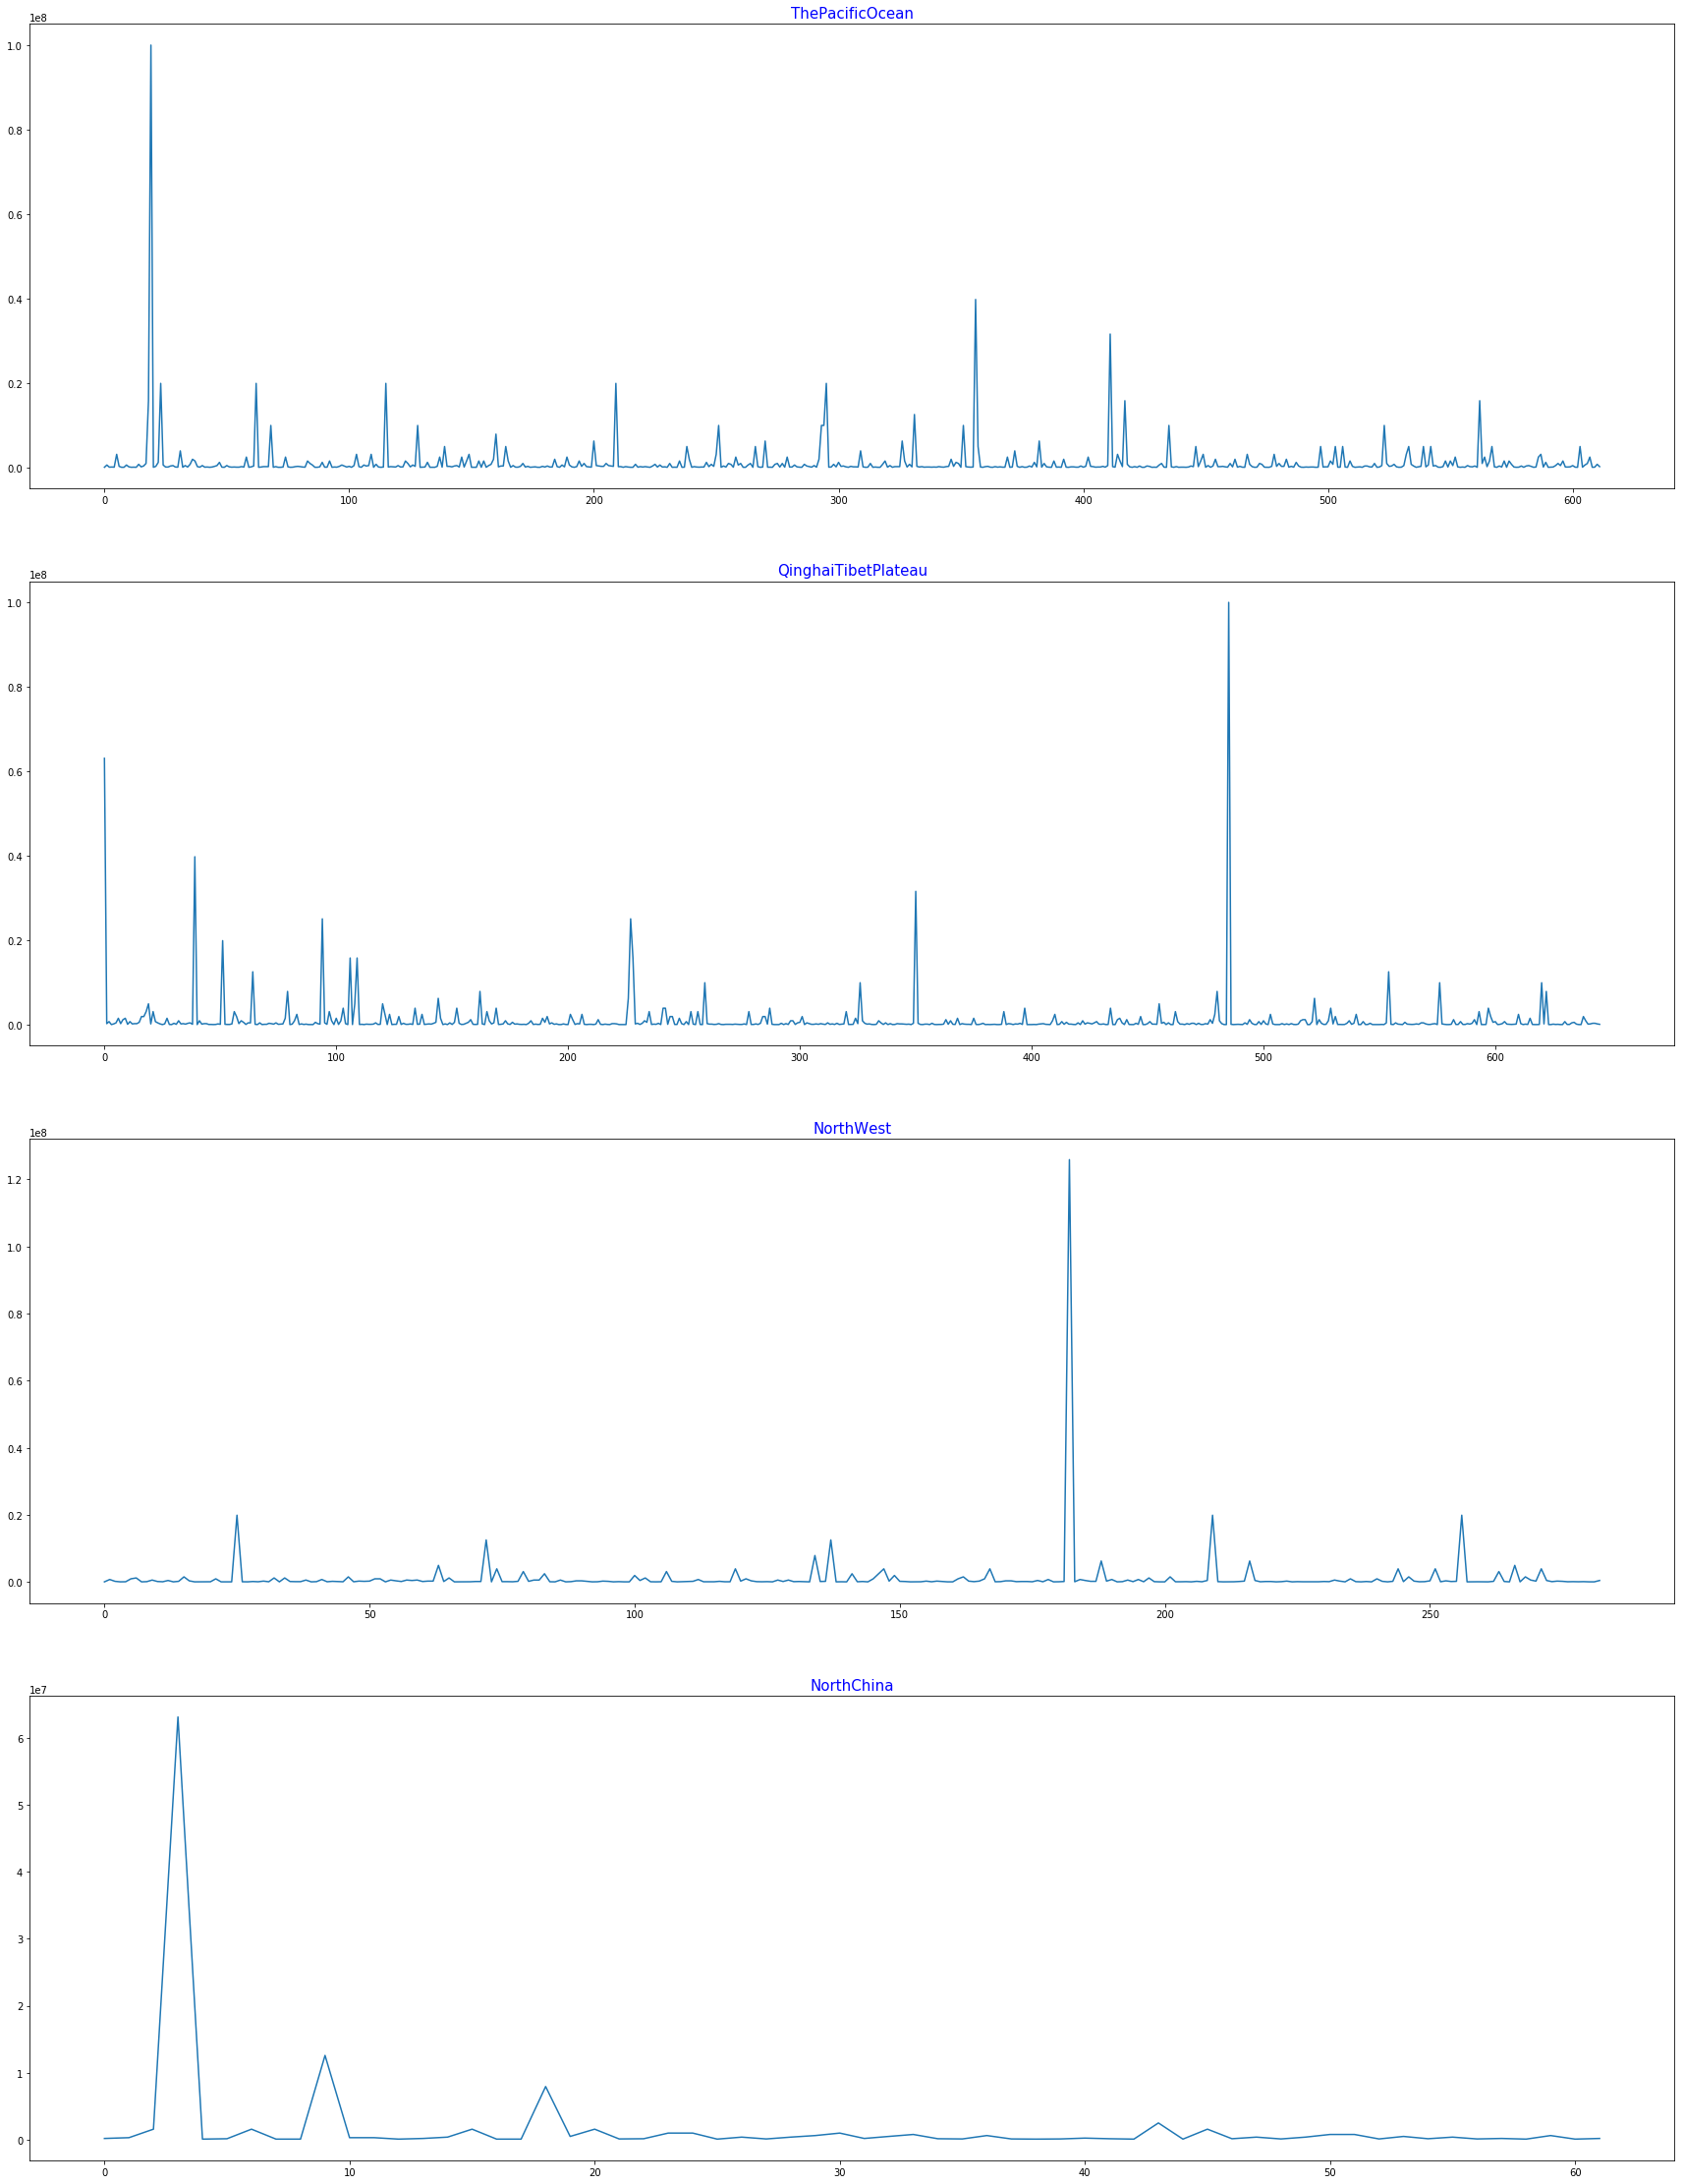

In [4]:
# 载入划分好的四个地震带数据（1970-2020），并可视化折线图
data_ThePacificOcean = read_data('./data/earthquake/ThePacificOcean1970-2019.csv', 1, '震级')
data_QinghaiTibetPlateau = read_data('./data/earthquake/QinghaiTibetPlateau1970-2019.csv', 1, '震级')
data_NorthWest = read_data('./data/earthquake/NorthWest1970-2019.csv', 1, '震级')
data_NorthChina = read_data('./data/earthquake/NorthChina1970-2019.csv', 1, '震级')
data_ThePacificOcean_energy = read_data('./data/earthquake/ThePacificOcean1970-2019.csv', 2, '能量')
data_QinghaiTibetPlateau_energy  = read_data('./data/earthquake/QinghaiTibetPlateau1970-2019.csv', 2, '能量')
data_NorthWest_energy  = read_data('./data/earthquake/NorthWest1970-2019.csv', 2, '能量')
data_NorthChina_energy  = read_data('./data/earthquake/NorthChina1970-2019.csv', 2, '能量')
print ("data_ThePacificOcean:%d"%len(data_ThePacificOcean))
print ("data_QinghaiTibetPlateau:%d"%len(data_QinghaiTibetPlateau)) 
print ("data_NorthWest:%d"%len(data_NorthWest)) 
print ("data_NorthChina:%d"%len(data_NorthChina)) 

show(data_ThePacificOcean,data_QinghaiTibetPlateau,data_NorthWest,data_NorthChina)
show(data_ThePacificOcean_energy,data_QinghaiTibetPlateau_energy,data_NorthWest_energy,data_NorthChina_energy)

### 3. 数据转化
- 采用时间窗方法划分数据，以使得时序预测问题可转换为传统的监督学习问题
- 转化为LSTM指定格式 [samples, time steps, features]

In [5]:
# 自定义多步预测的数据划分方法
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # 序列的结尾index
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # 检查是否越界
        if out_end_ix > len(sequence):
            break
        # 划分输入序列-X，输出序列-y
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [6]:
# 自定义数据预处理：数据划分 + 转化为时序神经网络指定格式 （样本个数，时间窗大小，输入的维度）
def data_pre(dataset, n_steps_in, n_steps_out):
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], 1)) 
    return X, y

In [7]:
# 选择时间窗口（输入步长，输出步长）
n_steps_in, n_steps_out = 30, 5

In [8]:
# 对四个地震带数据进行转化（震级）
X_tpo, y_tpo = data_pre(data_ThePacificOcean, n_steps_in, n_steps_out)
X_qtp, y_qtp = data_pre(data_QinghaiTibetPlateau, n_steps_in, n_steps_out)
X_nw, y_nw = data_pre(data_NorthWest, n_steps_in, n_steps_out)
X_nc, y_nc = data_pre(data_NorthChina, n_steps_in, n_steps_out)
# 对四个地震带数据进行转化（能量）
X_tpo_ey, y_tpo_ey = data_pre(data_ThePacificOcean_energy, n_steps_in, n_steps_out)
X_qtp_ey, y_qtp_ey = data_pre(data_QinghaiTibetPlateau_energy, n_steps_in, n_steps_out)
X_nw_ey, y_nw_ey = data_pre(data_NorthWest_energy, n_steps_in, n_steps_out)
X_nc_ey, y_nc_ey = data_pre(data_NorthChina_energy, n_steps_in, n_steps_out)
print(X_tpo.shape, y_tpo.shape)
print(X_qtp.shape, y_qtp.shape)
print(X_nw.shape, y_nw.shape)
print(X_nc.shape, y_nc.shape)

(578, 30, 1) (578, 5)
(612, 30, 1) (612, 5)
(249, 30, 1) (249, 5)
(28, 30, 1) (28, 5)


### 4. 构建Stacked LSTM、CNN、MLP模型分别进行多步预测

In [9]:
# Stacked LSTM
model1 = Sequential()
model1.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, 1))) # n_features取1
model1.add(LSTM(100, activation='relu'))
model1.add(Dense(n_steps_out))
model1.compile(optimizer='adam', loss='mse')
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 121,705
Trainable params: 121,705
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# CNN
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, 1))) # n_features取1
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(n_steps_out))
model2.compile(optimizer='adam', loss='mse')
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 29, 64)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                44850     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
Total params: 45,297
Trainable params: 45,297
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# MLP
model3 = Sequential()
model3.add(Dense(64, activation='relu', input_shape=(n_steps_in, 1)))
model3.add(Dense(10, activation='softmax'))
model3.add(Flatten())
model3.add(Dense(50, activation='relu'))
model3.add(Dense(n_steps_out))
model3.compile(optimizer='adam', loss='mse')
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30, 64)            128       
_________________________________________________________________
dense_5 (Dense)              (None, 30, 10)            650       
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 255       
Total params: 16,083
Trainable params: 16,083
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# 模型训练(环太平洋-震级)
model1.fit(X_tpo, y_tpo, epochs=100,batch_size=20, verbose=2)
model2.fit(X_tpo, y_tpo, epochs=100,batch_size=20, verbose=2)
model3.fit(X_tpo, y_tpo, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
1s - loss: 15.2774
Epoch 2/100
1s - loss: 0.8497
Epoch 3/100
1s - loss: 0.3934
Epoch 4/100
1s - loss: 0.3610
Epoch 5/100
1s - loss: 0.3396
Epoch 6/100
1s - loss: 0.3263
Epoch 7/100
1s - loss: 0.3236
Epoch 8/100
1s - loss: 0.3206
Epoch 9/100
1s - loss: 0.3268
Epoch 10/100
0s - loss: 0.3255
Epoch 11/100
0s - loss: 0.3203
Epoch 12/100
1s - loss: 0.3150
Epoch 13/100
0s - loss: 0.3187
Epoch 14/100
1s - loss: 0.3362
Epoch 15/100
0s - loss: 0.3200
Epoch 16/100
1s - loss: 0.3232
Epoch 17/100
1s - loss: 0.3211
Epoch 18/100
1s - loss: 0.3194
Epoch 19/100
0s - loss: 0.3188
Epoch 20/100
1s - loss: 0.3186
Epoch 21/100
1s - loss: 0.3192
Epoch 22/100
0s - loss: 0.3152
Epoch 23/100
1s - loss: 0.3136
Epoch 24/100
0s - loss: 0.3179
Epoch 25/100
1s - loss: 0.3128
Epoch 26/100
0s - loss: 0.3163
Epoch 27/100
1s - loss: 0.3137
Epoch 28/100
1s - loss: 0.3157
Epoch 29/100
1s - loss: 0.3158
Epoch 30/100
1s - loss: 0.3178
Epoch 31/100
1s - loss: 0.3208
Epoch 32/100
1s - loss: 0.3195
Epoch 33/100
1s 

Epoch 67/100
0s - loss: 0.3070
Epoch 68/100
0s - loss: 0.3117
Epoch 69/100
0s - loss: 0.3124
Epoch 70/100
0s - loss: 0.3088
Epoch 71/100
0s - loss: 0.3094
Epoch 72/100
0s - loss: 0.3111
Epoch 73/100
0s - loss: 0.3084
Epoch 74/100
0s - loss: 0.3062
Epoch 75/100
0s - loss: 0.3094
Epoch 76/100
0s - loss: 0.3066
Epoch 77/100
0s - loss: 0.3082
Epoch 78/100
0s - loss: 0.3076
Epoch 79/100
0s - loss: 0.3102
Epoch 80/100
0s - loss: 0.3069
Epoch 81/100
0s - loss: 0.3078
Epoch 82/100
0s - loss: 0.3124
Epoch 83/100
0s - loss: 0.3079
Epoch 84/100
0s - loss: 0.3097
Epoch 85/100
0s - loss: 0.3120
Epoch 86/100
0s - loss: 0.3087
Epoch 87/100
0s - loss: 0.3070
Epoch 88/100
0s - loss: 0.3119
Epoch 89/100
0s - loss: 0.3098
Epoch 90/100
0s - loss: 0.3092
Epoch 91/100
0s - loss: 0.3078
Epoch 92/100
0s - loss: 0.3139
Epoch 93/100
0s - loss: 0.3079
Epoch 94/100
0s - loss: 0.3090
Epoch 95/100
0s - loss: 0.3104
Epoch 96/100
0s - loss: 0.3090
Epoch 97/100
0s - loss: 0.3078
Epoch 98/100
0s - loss: 0.3067
Epoch 99

### 5. 模型预测

In [12]:
from sklearn.metrics import mean_squared_error # 均方误差
# 自定义预测
def pred(dataset, model):
    x_input = dataset[len(dataset)-n_steps_in:len(dataset)]
    x_input = x_input.reshape((1, n_steps_in, 1)) # n_features为1
    yhat = model.predict(x_input, verbose=0)
    y_pred = yhat.squeeze()
    return y_pred

In [20]:
# 根据震级预测2020年环太平洋地震带连续5次震级
y_pred1 = pred(data_ThePacificOcean, model1)
y_pred2 = pred(data_ThePacificOcean, model2)
y_pred3 = pred(data_ThePacificOcean, model3)
print(y_pred1)
print(y_pred2)
print(y_pred3)
y_true = read_data('./data/earthquake/ThePacificOcean_2020.csv', 0, '震级') 
y_true = y_true[0:5] # 取前5个值
print(y_true)
# 计算均方误差
print(mean_squared_error(y_true, y_pred1))
print(mean_squared_error(y_true, y_pred2))
print(mean_squared_error(y_true, y_pred3))

[5.4574027 5.387844  5.4933877 5.585852  5.4295034]
[5.7339845 5.5350394 5.492125  5.764018  5.4091487]
[5.5872264 5.4709935 5.5271955 5.50725   5.541057 ]
[5.3 5.4 5.8 5.1 5.4]
0.07117144842819659
0.14847376844965046
0.06954218676916937


In [21]:
# 模型训练(青藏高原-震级)
model1.fit(X_qtp, y_qtp, epochs=100,batch_size=20, verbose=2)
model2.fit(X_qtp, y_qtp, epochs=100,batch_size=20, verbose=2)
model3.fit(X_qtp, y_qtp, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
1s - loss: 0.3070
Epoch 2/100
1s - loss: 0.3013
Epoch 3/100
1s - loss: 0.3021
Epoch 4/100
1s - loss: 0.2986
Epoch 5/100
1s - loss: 0.3011
Epoch 6/100
1s - loss: 0.3031
Epoch 7/100
1s - loss: 0.2977
Epoch 8/100
1s - loss: 0.2974
Epoch 9/100
1s - loss: 0.2999
Epoch 10/100
1s - loss: 0.2991
Epoch 11/100
1s - loss: 0.3104
Epoch 12/100
1s - loss: 0.3063
Epoch 13/100
1s - loss: 0.3058
Epoch 14/100
1s - loss: 0.3074
Epoch 15/100
1s - loss: 0.3006
Epoch 16/100
1s - loss: 0.2971
Epoch 17/100
1s - loss: 0.2978
Epoch 18/100
1s - loss: 0.3003
Epoch 19/100
1s - loss: 0.3023
Epoch 20/100
1s - loss: 0.3022
Epoch 21/100
1s - loss: 0.2969
Epoch 22/100
1s - loss: 0.2994
Epoch 23/100
1s - loss: 0.3007
Epoch 24/100
1s - loss: 0.3021
Epoch 25/100
1s - loss: 0.3003
Epoch 26/100
1s - loss: 0.3016
Epoch 27/100
1s - loss: 0.2989
Epoch 28/100
1s - loss: 0.3003
Epoch 29/100
1s - loss: 0.3029
Epoch 30/100
1s - loss: 0.3025
Epoch 31/100
1s - loss: 0.2982
Epoch 32/100
1s - loss: 0.2975
Epoch 33/100
1s -

0s - loss: 0.2751
Epoch 68/100
0s - loss: 0.2760
Epoch 69/100
0s - loss: 0.2762
Epoch 70/100
0s - loss: 0.2737
Epoch 71/100
0s - loss: 0.2723
Epoch 72/100
0s - loss: 0.2737
Epoch 73/100
0s - loss: 0.2719
Epoch 74/100
0s - loss: 0.2726
Epoch 75/100
0s - loss: 0.2742
Epoch 76/100
0s - loss: 0.2716
Epoch 77/100
0s - loss: 0.2736
Epoch 78/100
0s - loss: 0.2714
Epoch 79/100
0s - loss: 0.2721
Epoch 80/100
0s - loss: 0.2719
Epoch 81/100
0s - loss: 0.2710
Epoch 82/100
0s - loss: 0.2715
Epoch 83/100
0s - loss: 0.2767
Epoch 84/100
0s - loss: 0.2717
Epoch 85/100
0s - loss: 0.2718
Epoch 86/100
0s - loss: 0.2725
Epoch 87/100
0s - loss: 0.2754
Epoch 88/100
0s - loss: 0.2759
Epoch 89/100
0s - loss: 0.2733
Epoch 90/100
0s - loss: 0.2712
Epoch 91/100
0s - loss: 0.2692
Epoch 92/100
0s - loss: 0.2714
Epoch 93/100
0s - loss: 0.2738
Epoch 94/100
0s - loss: 0.2735
Epoch 95/100
0s - loss: 0.2707
Epoch 96/100
0s - loss: 0.2717
Epoch 97/100
0s - loss: 0.2706
Epoch 98/100
0s - loss: 0.2693
Epoch 99/100
0s - los

In [22]:
# 根据震级预测2020年青藏高原地震带连续5次震级
y_pred1 = pred(data_QinghaiTibetPlateau, model1)
y_pred2 = pred(data_QinghaiTibetPlateau, model2)
y_pred3 = pred(data_QinghaiTibetPlateau, model3)
print(y_pred1)
print(y_pred2)
print(y_pred3)
y_true = read_data('./data/earthquake/QinghaiTibetPlateau_2020.csv', 0, '震级') 
y_true = y_true[0:5] # 取前5个值
print(y_true)
# 计算均方误差
print(mean_squared_error(y_true, y_pred1))
print(mean_squared_error(y_true, y_pred2))
print(mean_squared_error(y_true, y_pred3))

[5.4193487 5.38035   5.3093596 5.423652  5.5111423]
[5.4360285 5.5563393 5.469944  5.265222  5.4419303]
[5.5526576 5.503762  5.287227  5.18943   5.4823375]
[5.1 5.1 5.  5.  5.1]
0.12496044720009755
0.1458534201318218
0.12649753387433174


In [23]:
# 模型训练(西北-震级)
model1.fit(X_nw, y_nw, epochs=100,batch_size=20, verbose=2)
model2.fit(X_nw, y_nw, epochs=100,batch_size=20, verbose=2)
model3.fit(X_nw, y_nw, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 0.2991
Epoch 2/100
0s - loss: 0.2948
Epoch 3/100
0s - loss: 0.2930
Epoch 4/100
0s - loss: 0.2907
Epoch 5/100
0s - loss: 0.2905
Epoch 6/100
0s - loss: 0.2884
Epoch 7/100
0s - loss: 0.2907
Epoch 8/100
0s - loss: 0.2934
Epoch 9/100
0s - loss: 0.2922
Epoch 10/100
0s - loss: 0.2916
Epoch 11/100
0s - loss: 0.2958
Epoch 12/100
0s - loss: 0.2929
Epoch 13/100
0s - loss: 0.2868
Epoch 14/100
0s - loss: 0.2914
Epoch 15/100
0s - loss: 0.2946
Epoch 16/100
0s - loss: 0.2950
Epoch 17/100
0s - loss: 0.2890
Epoch 18/100
0s - loss: 0.2983
Epoch 19/100
0s - loss: 0.2922
Epoch 20/100
0s - loss: 0.2870
Epoch 21/100
0s - loss: 0.2902
Epoch 22/100
0s - loss: 0.2905
Epoch 23/100
0s - loss: 0.2872
Epoch 24/100
0s - loss: 0.2932
Epoch 25/100
0s - loss: 0.2937
Epoch 26/100
0s - loss: 0.2920
Epoch 27/100
0s - loss: 0.2919
Epoch 28/100
0s - loss: 0.2877
Epoch 29/100
0s - loss: 0.2959
Epoch 30/100
0s - loss: 0.2945
Epoch 31/100
0s - loss: 0.2883
Epoch 32/100
0s - loss: 0.2905
Epoch 33/100
0s -

0s - loss: 0.2796
Epoch 70/100
0s - loss: 0.2711
Epoch 71/100
0s - loss: 0.2735
Epoch 72/100
0s - loss: 0.2723
Epoch 73/100
0s - loss: 0.2777
Epoch 74/100
0s - loss: 0.2730
Epoch 75/100
0s - loss: 0.2713
Epoch 76/100
0s - loss: 0.2692
Epoch 77/100
0s - loss: 0.2703
Epoch 78/100
0s - loss: 0.2684
Epoch 79/100
0s - loss: 0.2710
Epoch 80/100
0s - loss: 0.2687
Epoch 81/100
0s - loss: 0.2681
Epoch 82/100
0s - loss: 0.2692
Epoch 83/100
0s - loss: 0.2703
Epoch 84/100
0s - loss: 0.2730
Epoch 85/100
0s - loss: 0.2671
Epoch 86/100
0s - loss: 0.2689
Epoch 87/100
0s - loss: 0.2695
Epoch 88/100
0s - loss: 0.2649
Epoch 89/100
0s - loss: 0.2673
Epoch 90/100
0s - loss: 0.2640
Epoch 91/100
0s - loss: 0.2664
Epoch 92/100
0s - loss: 0.2649
Epoch 93/100
0s - loss: 0.2656
Epoch 94/100
0s - loss: 0.2652
Epoch 95/100
0s - loss: 0.2656
Epoch 96/100
0s - loss: 0.2625
Epoch 97/100
0s - loss: 0.2684
Epoch 98/100
0s - loss: 0.2723
Epoch 99/100
0s - loss: 0.2668
Epoch 100/100
0s - loss: 0.2682


In [24]:
# 根据震级预测2020年西北地震带连续5次震级
y_pred1 = pred(data_NorthWest, model1)
y_pred2 = pred(data_NorthWest, model2)
y_pred3 = pred(data_NorthWest, model3)
print(y_pred1)
print(y_pred2)
print(y_pred3)
y_true = read_data('./data/earthquake/NorthWest_2020.csv', 0, '震级') 
y_true = y_true[0:5] # 取前5个值
print(y_true)
# 计算均方误差
print(mean_squared_error(y_true, y_pred1))
print(mean_squared_error(y_true, y_pred2))
print(mean_squared_error(y_true, y_pred3))

[5.5896587 5.4691586 5.557145  5.5192885 5.54045  ]
[5.7938323 5.7234406 5.3174243 5.614575  5.4871917]
[5.5825167 5.7704525 5.2471275 5.414     5.5893497]
[5.6 5.4 6.4 5.2 5.1]
0.20224713406048628
0.3271889431420515
0.3503829671357618


In [25]:
# 模型训练（华北-震级）
model1.fit(X_nc, y_nc, epochs=100,batch_size=20, verbose=2)
model2.fit(X_nc, y_nc, epochs=100,batch_size=20, verbose=2)
model3.fit(X_nc, y_nc, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 0.1591
Epoch 2/100
0s - loss: 0.1504
Epoch 3/100
0s - loss: 0.1535
Epoch 4/100
0s - loss: 0.1540
Epoch 5/100
0s - loss: 0.1492
Epoch 6/100
0s - loss: 0.1532
Epoch 7/100
0s - loss: 0.1481
Epoch 8/100
0s - loss: 0.1488
Epoch 9/100
0s - loss: 0.1524
Epoch 10/100
0s - loss: 0.1497
Epoch 11/100
0s - loss: 0.1489
Epoch 12/100
0s - loss: 0.1481
Epoch 13/100
0s - loss: 0.1468
Epoch 14/100
0s - loss: 0.1477
Epoch 15/100
0s - loss: 0.1476
Epoch 16/100
0s - loss: 0.1471
Epoch 17/100
0s - loss: 0.1452
Epoch 18/100
0s - loss: 0.1453
Epoch 19/100
0s - loss: 0.1469
Epoch 20/100
0s - loss: 0.1456
Epoch 21/100
0s - loss: 0.1473
Epoch 22/100
0s - loss: 0.1440
Epoch 23/100
0s - loss: 0.1466
Epoch 24/100
0s - loss: 0.1441
Epoch 25/100
0s - loss: 0.1451
Epoch 26/100
0s - loss: 0.1449
Epoch 27/100
0s - loss: 0.1452
Epoch 28/100
0s - loss: 0.1446
Epoch 29/100
0s - loss: 0.1437
Epoch 30/100
0s - loss: 0.1448
Epoch 31/100
0s - loss: 0.1428
Epoch 32/100
0s - loss: 0.1466
Epoch 33/100
0s -

0s - loss: 0.1543
Epoch 72/100
0s - loss: 0.1520
Epoch 73/100
0s - loss: 0.1523
Epoch 74/100
0s - loss: 0.1552
Epoch 75/100
0s - loss: 0.1568
Epoch 76/100
0s - loss: 0.1567
Epoch 77/100
0s - loss: 0.1566
Epoch 78/100
0s - loss: 0.1538
Epoch 79/100
0s - loss: 0.1517
Epoch 80/100
0s - loss: 0.1508
Epoch 81/100
0s - loss: 0.1514
Epoch 82/100
0s - loss: 0.1527
Epoch 83/100
0s - loss: 0.1510
Epoch 84/100
0s - loss: 0.1503
Epoch 85/100
0s - loss: 0.1506
Epoch 86/100
0s - loss: 0.1501
Epoch 87/100
0s - loss: 0.1499
Epoch 88/100
0s - loss: 0.1485
Epoch 89/100
0s - loss: 0.1492
Epoch 90/100
0s - loss: 0.1502
Epoch 91/100
0s - loss: 0.1494
Epoch 92/100
0s - loss: 0.1484
Epoch 93/100
0s - loss: 0.1480
Epoch 94/100
0s - loss: 0.1475
Epoch 95/100
0s - loss: 0.1478
Epoch 96/100
0s - loss: 0.1470
Epoch 97/100
0s - loss: 0.1469
Epoch 98/100
0s - loss: 0.1463
Epoch 99/100
0s - loss: 0.1454
Epoch 100/100
0s - loss: 0.1460


In [26]:
# 根据震级预测2020年华北地震带连续5次震级
y_pred1 = pred(data_NorthWest, model1)
y_pred2 = pred(data_NorthWest, model2)
y_pred3 = pred(data_NorthWest, model3)
print(y_pred1)
print(y_pred2)
print(y_pred3)
y_true = read_data('./data/earthquake/NorthWest_2020.csv', 0, '震级') 
y_true = y_true[0:5] # 取前5个值
print(y_true)
# 计算均方误差
print(mean_squared_error(y_true, y_pred1))
print(mean_squared_error(y_true, y_pred2))
print(mean_squared_error(y_true, y_pred3))

[5.6108003 5.570628  5.598634  5.6636343 5.565972 ]
[5.284962 5.389722 5.067878 5.237946 4.900896]
[5.5686502 5.5103498 5.249938  5.4869037 5.59175  ]
[5.6 5.4 6.4 5.2 5.1]
0.22070099763375411
0.3829972764425803
0.3319868744304369


In [18]:
# 模型训练(环太平洋能量)
model1.fit(X_tpo_ey, y_tpo_ey, epochs=100,batch_size=20, verbose=2)
model2.fit(X_tpo_ey, y_tpo_ey, epochs=100,batch_size=20, verbose=2)
model3.fit(X_tpo_ey, y_tpo_ey, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
1s - loss: 11544745665674.1855
Epoch 2/100
1s - loss: 11233376249026.8789
Epoch 3/100
1s - loss: 10978731831480.2480
Epoch 4/100
1s - loss: 11051178572293.3164
Epoch 5/100
1s - loss: 11085150152952.0273
Epoch 6/100
1s - loss: 11210722677969.0527
Epoch 7/100
1s - loss: 11127021922892.1797
Epoch 8/100
1s - loss: 11049617463955.0449
Epoch 9/100
1s - loss: 11034853698010.7949
Epoch 10/100
0s - loss: 11019329649610.8516
Epoch 11/100
1s - loss: 11067158886860.6230
Epoch 12/100
1s - loss: 11025387264545.6602
Epoch 13/100
1s - loss: 10857974125720.3594
Epoch 14/100
1s - loss: 10957610597322.8516
Epoch 15/100
1s - loss: 10777450430293.9238
Epoch 16/100
1s - loss: 10696507762539.1836
Epoch 17/100
1s - loss: 10671916915573.8145
Epoch 18/100
1s - loss: 10557445611605.0391
Epoch 19/100
1s - loss: 10461958558872.3594
Epoch 20/100
1s - loss: 10546827164562.1602
Epoch 21/100
0s - loss: 10579394211230.5605
Epoch 22/100
1s - loss: 10528367063451.0176
Epoch 23/100
1s - loss: 10498413748932.65

0s - loss: 5511763889594.9072
Epoch 94/100
0s - loss: 5586242721260.5117
Epoch 95/100
0s - loss: 5628578268836.7607
Epoch 96/100
0s - loss: 5377489673191.1973
Epoch 97/100
0s - loss: 5314638584693.8125
Epoch 98/100
0s - loss: 5317135695872.0000
Epoch 99/100
0s - loss: 5307063223575.9170
Epoch 100/100
0s - loss: 5239342468312.1387
Epoch 1/100
0s - loss: 11381463947129.3555
Epoch 2/100
0s - loss: 11381089037669.8691
Epoch 3/100
0s - loss: 11380720951210.9609
Epoch 4/100
0s - loss: 11380342749077.7031
Epoch 5/100
0s - loss: 11379964585268.2637
Epoch 6/100
0s - loss: 11379580032946.0488
Epoch 7/100
0s - loss: 11379202932452.5410
Epoch 8/100
0s - loss: 11378807098187.2930
Epoch 9/100
0s - loss: 11378423425952.3320
Epoch 10/100
0s - loss: 11378029831249.4941
Epoch 11/100
0s - loss: 11377636038804.8164
Epoch 12/100
0s - loss: 11377240402734.9473
Epoch 13/100
0s - loss: 11376840414530.4355
Epoch 14/100
0s - loss: 11376439754185.0781
Epoch 15/100
0s - loss: 11376032991054.8379
Epoch 16/100
0s -

In [19]:
# 根据能量预测2020年环太平洋地震带连续5次震级
y_pred1 = pred(data_ThePacificOcean_energy, model1)
y_pred2 = pred(data_ThePacificOcean_energy, model2)
y_pred3 = pred(data_ThePacificOcean_energy, model3)
y_pred1 = np.log10(y_pred1)
y_pred2 = np.log10(y_pred2)
y_pred3 = np.log10(y_pred3)
# nan值用均值替代
y_pred1[np.isnan(y_pred1)] = np.nanmean(y_pred1)
y_pred2[np.isnan(y_pred2)] = np.nanmean(y_pred2)
y_pred2[np.isnan(y_pred3)] = np.nanmean(y_pred3)
print(y_pred1)
print(y_pred2)
print(y_pred3)
y_true = read_data('./data/earthquake/ThePacificOcean_2020.csv', 0, '震级') 
y_true = y_true[0:5] # 取前5个值
print(y_true)
# 计算均方误差
print(mean_squared_error(y_true, y_pred1))
print(mean_squared_error(y_true, y_pred2))
print(mean_squared_error(y_true, y_pred3))

[6.0397735 6.0889173 6.049563  6.141737  6.151969 ]
[6.2991834 6.058494  6.0057325 5.888892  6.063076 ]
[4.6426463 4.6447725 4.643794  4.644389  4.6449804]
[5.3 5.4 5.8 5.1 5.4]
0.5469653349654091
0.5072656835725248
0.6233860746003502


C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


In [15]:
# 模型训练(青藏高原-能量)
model1.fit(X_qtp_ey, y_qtp_ey, epochs=100,batch_size=20, verbose=2)
model2.fit(X_qtp_ey, y_qtp_ey, epochs=100,batch_size=20, verbose=2)
model3.fit(X_qtp_ey, y_qtp_ey, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
1s - loss: 26433121702824.9922
Epoch 2/100
1s - loss: 26360535769998.2227
Epoch 3/100
1s - loss: 26403254873603.3477
Epoch 4/100
1s - loss: 26302078944731.1875
Epoch 5/100
1s - loss: 26289712155038.9570
Epoch 6/100
1s - loss: 26748222524235.2930
Epoch 7/100
1s - loss: 26543517819576.0508
Epoch 8/100
1s - loss: 26524526390144.8359
Epoch 9/100
1s - loss: 26700700289760.2070
Epoch 10/100
1s - loss: 26527922811335.1133
Epoch 11/100
1s - loss: 26499745629552.1055
Epoch 12/100
1s - loss: 26458466467518.7422
Epoch 13/100
1s - loss: 26610661938945.6719
Epoch 14/100
1s - loss: 26357426651350.1680
Epoch 15/100
1s - loss: 26235574802820.1836
Epoch 16/100
1s - loss: 26397897100856.8867
Epoch 17/100
1s - loss: 26311129040561.3594
Epoch 18/100
1s - loss: 26485243231506.4023
Epoch 19/100
1s - loss: 26975655821312.0000
Epoch 20/100
1s - loss: 26517733468521.4102
Epoch 21/100
1s - loss: 26367837356353.2578
Epoch 22/100
1s - loss: 26358867138198.5898
Epoch 23/100
1s - loss: 26219597321343.16

0s - loss: 19826115721657.7227
Epoch 92/100
0s - loss: 18935430084300.1328
Epoch 93/100
0s - loss: 18776804078772.7070
Epoch 94/100
0s - loss: 18927388962735.6875
Epoch 95/100
0s - loss: 18839948384858.3516
Epoch 96/100
0s - loss: 18776409576039.7383
Epoch 97/100
0s - loss: 18503085005937.7773
Epoch 98/100
0s - loss: 18951191673916.2344
Epoch 99/100
0s - loss: 18674602684549.8555
Epoch 100/100
0s - loss: 19174637651097.9375
Epoch 1/100
0s - loss: 27222325354763.7109
Epoch 2/100
0s - loss: 27222008773906.4023
Epoch 3/100
0s - loss: 27221699627315.8672
Epoch 4/100
0s - loss: 27221387989072.3125
Epoch 5/100
0s - loss: 27221075939622.4844
Epoch 6/100
0s - loss: 27220762316880.3125
Epoch 7/100
0s - loss: 27220445335953.5664
Epoch 8/100
0s - loss: 27220139819115.0820
Epoch 9/100
0s - loss: 27219820992900.1836
Epoch 10/100
0s - loss: 27219511763640.0508
Epoch 11/100
0s - loss: 27219187614445.5977
Epoch 12/100
0s - loss: 27218878907331.7656
Epoch 13/100
0s - loss: 27218558244395.5039
Epoch 14/

In [17]:
# 根据能量预测2020年青藏高原地震带连续5次震级
y_pred1 = pred(data_QinghaiTibetPlateau_energy, model1)
y_pred2 = pred(data_QinghaiTibetPlateau_energy, model2)
y_pred3 = pred(data_QinghaiTibetPlateau_energy, model3)
y_pred1 = np.log10(y_pred1)
y_pred2 = np.log10(y_pred2)
y_pred3 = np.log10(y_pred3)
# nan值用均值替代
y_pred1[np.isnan(y_pred1)] = np.nanmean(y_pred1)
y_pred2[np.isnan(y_pred2)] = np.nanmean(y_pred2)
y_pred2[np.isnan(y_pred3)] = np.nanmean(y_pred3)
print(y_pred1)
print(y_pred2)
print(y_pred3)
y_true = read_data('./data/earthquake/QinghaiTibetPlateau_2020.csv', 0, '震级') 
y_true = y_true[0:5] # 取前5个值
print(y_true)
# 计算均方误差
print(mean_squared_error(y_true, y_pred1))
print(mean_squared_error(y_true, y_pred2))
print(mean_squared_error(y_true, y_pred3))

[6.248019 6.176115 6.179314 6.175588 6.177913]
[6.2252707 6.350517  6.002956  6.2252707 6.32234  ]
[4.3480964 4.3514867 4.3503966 4.3505435 4.3506203]
[5.1 5.1 5.  5.  5.1]
1.2821315651438332
1.3662701177361092
0.5061959029288625


C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


In [20]:
# 模型训练(西北-能量)
model1.fit(X_nw_ey, y_nw_ey, epochs=100,batch_size=20, verbose=2)
model2.fit(X_nw_ey, y_nw_ey, epochs=100,batch_size=20, verbose=2)
model3.fit(X_nw_ey, y_nw_ey, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 69280808665745.9922
Epoch 2/100
0s - loss: 68956043514365.9453
Epoch 3/100
0s - loss: 68855743596272.5781
Epoch 4/100
0s - loss: 68778545898294.4922
Epoch 5/100
0s - loss: 68652679558057.6328
Epoch 6/100
0s - loss: 68569073036209.8594
Epoch 7/100
0s - loss: 68437612786206.8438
Epoch 8/100
0s - loss: 68444207098538.6641
Epoch 9/100
0s - loss: 68388602684543.4922
Epoch 10/100
0s - loss: 68607601838005.9766
Epoch 11/100
0s - loss: 68632316378478.0078
Epoch 12/100
0s - loss: 68313142700714.6641
Epoch 13/100
0s - loss: 68179798476528.5781
Epoch 14/100
0s - loss: 68144420315037.3047
Epoch 15/100
0s - loss: 68429217509853.0469
Epoch 16/100
0s - loss: 68346584421322.5312
Epoch 17/100
0s - loss: 68163039744312.5391
Epoch 18/100
0s - loss: 68245847093330.2500
Epoch 19/100
0s - loss: 67883745554251.0547
Epoch 20/100
0s - loss: 67892800502821.0156
Epoch 21/100
0s - loss: 68012095886808.9297
Epoch 22/100
0s - loss: 67866885658665.1250
Epoch 23/100
0s - loss: 67805282564038.42

Epoch 91/100
0s - loss: 55967038212548.3750
Epoch 92/100
0s - loss: 55372734437943.5156
Epoch 93/100
0s - loss: 54762976536534.8750
Epoch 94/100
0s - loss: 54403383650262.8750
Epoch 95/100
0s - loss: 54395752857402.6016
Epoch 96/100
0s - loss: 54051772612936.9922
Epoch 97/100
0s - loss: 53727293376437.9766
Epoch 98/100
0s - loss: 53569874122069.3359
Epoch 99/100
0s - loss: 53454983386321.7344
Epoch 100/100
0s - loss: 54001994234061.6172
Epoch 1/100
0s - loss: 69632971307740.0156
Epoch 2/100
0s - loss: 69632610819734.1016
Epoch 3/100
0s - loss: 69632247070193.6016
Epoch 4/100
0s - loss: 69631884366070.7422
Epoch 5/100
0s - loss: 69631510879301.9141
Epoch 6/100
0s - loss: 69631176219323.1172
Epoch 7/100
0s - loss: 69630811348564.3047
Epoch 8/100
0s - loss: 69630458634075.5000
Epoch 9/100
0s - loss: 69630110411303.0703
Epoch 10/100
0s - loss: 69629798199904.6406
Epoch 11/100
0s - loss: 69629431251996.7891
Epoch 12/100
0s - loss: 69629075698404.2422
Epoch 13/100
0s - loss: 69628743114521.7

In [21]:
# 根据能量预测2020年西北地震带连续5次震级
y_pred1 = pred(data_NorthWest_energy, model1)
y_pred2 = pred(data_NorthWest_energy, model2)
y_pred3 = pred(data_NorthWest_energy, model3)
y_pred1 = np.log10(y_pred1)
y_pred2 = np.log10(y_pred2)
y_pred3 = np.log10(y_pred3)
# nan值用均值替代
y_pred1[np.isnan(y_pred1)] = np.nanmean(y_pred1)
y_pred2[np.isnan(y_pred2)] = np.nanmean(y_pred2)
y_pred2[np.isnan(y_pred3)] = np.nanmean(y_pred3)
print(y_pred1)
print(y_pred2)
print(y_pred3)
y_true = read_data('./data/earthquake/NorthWest_2020.csv', 0, '震级') 
y_true = y_true[0:5] # 取前5个值
print(y_true)
# 计算均方误差
print(mean_squared_error(y_true, y_pred1))
print(mean_squared_error(y_true, y_pred2))
print(mean_squared_error(y_true, y_pred3))

[5.1769404 5.1046185 5.3432264 5.3031816 5.389496 ]
[6.6722245 6.513114  6.354004  6.513114  6.513114 ]
[4.7443676 4.7460794 4.7451324 4.745557  4.745803 ]
[5.6 5.4 6.4 5.2 5.1]
0.29549085270987796
1.222392641698267
0.8460559422692097


C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


In [22]:
# 模型训练（华北-能量）
model1.fit(X_nc_ey, y_nc_ey, epochs=100,batch_size=20, verbose=2)
model2.fit(X_nc_ey, y_nc_ey, epochs=100,batch_size=20, verbose=2)
model3.fit(X_nc_ey, y_nc_ey, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 1090012418633.1428
Epoch 2/100
0s - loss: 921294995456.0000
Epoch 3/100
0s - loss: 571098885558.8572
Epoch 4/100
0s - loss: 434118403218.2857
Epoch 5/100
0s - loss: 390056677961.1428
Epoch 6/100
0s - loss: 460988977737.1428
Epoch 7/100
0s - loss: 430437906139.4286
Epoch 8/100
0s - loss: 520220082176.0000
Epoch 9/100
0s - loss: 487933568146.2857
Epoch 10/100
0s - loss: 417901019136.0000
Epoch 11/100
0s - loss: 389660854564.5714
Epoch 12/100
0s - loss: 380256873910.8572
Epoch 13/100
0s - loss: 376378645357.7143
Epoch 14/100
0s - loss: 394067537334.8572
Epoch 15/100
0s - loss: 381663519890.2857
Epoch 16/100
0s - loss: 378132402761.1428
Epoch 17/100
0s - loss: 371504026185.1428
Epoch 18/100
0s - loss: 379858592914.2857
Epoch 19/100
0s - loss: 441579953005.7143
Epoch 20/100
0s - loss: 438362566070.8572
Epoch 21/100
0s - loss: 435697694427.4286
Epoch 22/100
0s - loss: 417370636288.0000
Epoch 23/100
0s - loss: 397592943469.7143
Epoch 24/100
0s - loss: 378977508205.7143


Epoch 19/100
0s - loss: 408061790500.5714
Epoch 20/100
0s - loss: 408058363904.0000
Epoch 21/100
0s - loss: 408054604946.2857
Epoch 22/100
0s - loss: 408050895140.5714
Epoch 23/100
0s - loss: 408047751753.1428
Epoch 24/100
0s - loss: 408043978752.0000
Epoch 25/100
0s - loss: 408040369590.8572
Epoch 26/100
0s - loss: 408036619995.4286
Epoch 27/100
0s - loss: 408032978066.2857
Epoch 28/100
0s - loss: 408029504658.2857
Epoch 29/100
0s - loss: 408025853366.8572
Epoch 30/100
0s - loss: 408022192713.1428
Epoch 31/100
0s - loss: 408018550784.0000
Epoch 32/100
0s - loss: 408014843318.8572
Epoch 33/100
0s - loss: 408011182665.1428
Epoch 34/100
0s - loss: 408007554779.4286
Epoch 35/100
0s - loss: 408003870720.0000
Epoch 36/100
0s - loss: 408000432420.5714
Epoch 37/100
0s - loss: 407996797513.1428
Epoch 38/100
0s - loss: 407992928548.5714
Epoch 39/100
0s - loss: 407989607277.7143
Epoch 40/100
0s - loss: 407986040246.8572
Epoch 41/100
0s - loss: 407982496621.7143
Epoch 42/100
0s - loss: 4079789108

In [25]:
# 根据能量预测2020年华北地震带连续5次震级 （华北2020年5级以上地震只有1次）
y_pred1 = pred(data_NorthChina_energy, model1)
y_pred2 = pred(data_NorthChina_energy, model2)
y_pred3 = pred(data_NorthChina_energy, model3)
y_pred1 = np.log10(y_pred1)
y_pred2 = np.log10(y_pred2)
y_pred3 = np.log10(y_pred3)
# nan值用均值替代
y_pred1[np.isnan(y_pred1)] = np.nanmean(y_pred1)
y_pred2[np.isnan(y_pred2)] = np.nanmean(y_pred2)
y_pred2[np.isnan(y_pred3)] = np.nanmean(y_pred3)
print(y_pred1[0])
print(y_pred2[0])
print(y_pred3[0])
y_true = read_data('./data/earthquake/NorthChina_2020.csv', 0, '震级') 
y_true = y_true[0] 
print(y_true)

5.1292024
5.8725567
4.748646
5.1
